# 1 Monte-Carlo Simulation

## 1.1 Data Creation and Visualization

In [12]:
from typing import Tuple, List, Set

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")


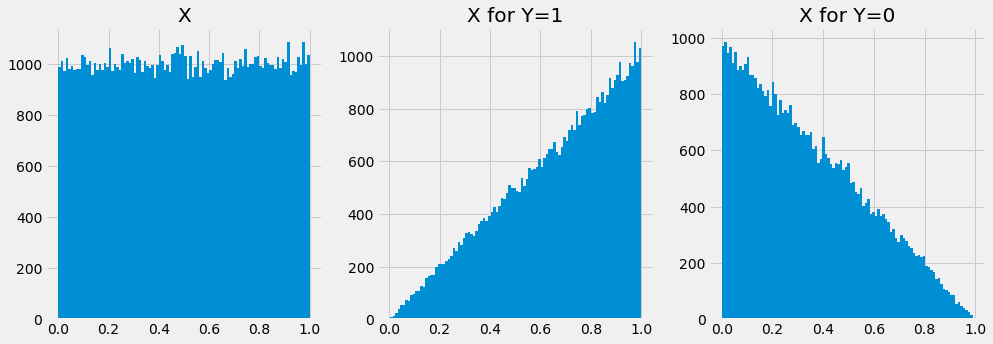

In [30]:
def create_data(N: int) -> Tuple[np.ndarray, np.ndarray]:
    label_y = np.random.randint(2, size=N)  # prior probability = 1/2
    u = np.random.uniform(0, 1, size=N)
    feature_x = np.array([np.sqrt(_u) if y==1 else 1 - np.sqrt(1-_u) for _u, y in zip(u, label_y)])
    return feature_x, label_y

    
_datax, _datay = create_data(100000)

fig: plt.Figure
ax: List[plt.Axes]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

_ = ax[0].hist(_datax, bins=100)
_ = ax[0].set_title("X")
_ = ax[1].hist([x for x, y in zip(_datax, _datay) if y==1], bins=100)
_ = ax[1].set_title("X for Y=1")
_ = ax[2].hist([x for x, y in zip(_datax, _datay) if y==0], bins=100)
_ = ax[2].set_title("X for Y=0")




## 1.2 Classification by Tresholding

In [ ]:
def rule_a(features_x: np.ndarray, x_treshold: float) -> np.ndarray:
    return np.array([0 if x < x_treshold else 1 for x in features_x])

def rule_b(features_x: np.ndarray, x_treshold: float) -> np.ndarray:
    return np.array([1 if x < x_treshold else 0 for x in features_x])

def error_prob_rule_a(x_treshold: float) -> float:
    return 0.25 + (x_treshold - 0.5)**2

def error_prob_rule_b(x_treshold: float) -> float:
    return 0.75 + (x_treshold - 0.5)**2

x_t: List[float] = [0.0, 0.2, 0.5, 0.6]
M: Set[int] = {10, 100, 1000, 10000}
for treshold in x_t:
    for m in M:
        for i in range(10):
            x, y = create_data(m)



## 1.3 Baseline Classifiers

In [ ]:
def rule_c():
    ...

def rule_d():
    ...

## 1.4 Nearest Neighbor Classification

In [ ]:
def toy_nearest_neighbor(XTest: np.ndarray, Xtrain: np.ndarray, YTrain: np.ndarray) -> np.ndarray:
    ...